# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно **построить модель для определения стоимости автомобиля**. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание исходных данных

Признаки, доступные для исследования:
- **DateCrawled** — дата скачивания анкеты из базы,
- **VehicleType** — тип автомобильного кузова,
- **RegistrationYear** — год регистрации автомобиля,
- **Gearbox** — тип коробки передач,
- **Power** — мощность (л. с.),
- **Model** — модель автомобиля,
- **Kilometer** — пробег (км),
- **RegistrationMonth** — месяц регистрации автомобиля,
- **FuelType** — тип топлива,
- **Brand** — марка автомобиля,
- **NotRepaired** — была машина в ремонте или нет,
- **DateCreated** — дата создания анкеты,
- **NumberOfPictures** — количество фотографий автомобиля,
- **PostalCode** — почтовый индекс владельца анкеты (пользователя),
- **LastSeen** — дата последней активности пользователя.    

Целевой признак:    **Price** — цена (евро)

## Подготовка данных

In [1]:
!pip install phik -q

Загружаем все библиотеки:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import time

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    StandardScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# зададим параметры окна вывода графиков
plt.rcParams["figure.figsize"] = (10,7)

In [3]:
# загружаем исходные данные в датафрейм и сразу преобразуем поля с датами в подходящий тип данных
try:
    df = pd.read_csv('c:/users/bny_7/datasets/autos.csv', sep=',', parse_dates=['DateCrawled','DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('/datasets/autos.csv', sep=',', parse_dates=['DateCrawled','DateCreated', 'LastSeen'])
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


**Проведем предобработку данных**

In [4]:
# выведем общую информацию о датафрейме
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

В наших данных:    
-    16 колонок,
-    354'369 записей,
-    есть пропуски в колонках:
        - VehicleType,
        - Gearbox,
        - Model,
        - FuelType,
        - Repaired.    
        
Типы данных соответствуют значениям в колонках.    
Посмотрим на содержимое колонок, подсчитаем количество пропусков:

In [5]:
for i in df.columns:
    k = df[i].isna().sum()
    print(f'В колонке {i} {k} пустых значений')
    display(df[i].value_counts())    

В колонке DateCrawled 0 пустых значений


2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-28 10:36:47    5
2016-03-19 12:50:39    5
                      ..
2016-03-21 11:45:06    1
2016-03-26 19:50:40    1
2016-03-17 09:50:45    1
2016-03-23 13:40:32    1
2016-03-10 16:49:49    1
Name: DateCrawled, Length: 271174, dtype: int64

В колонке Price 0 пустых значений


0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

В колонке VehicleType 37490 пустых значений


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

В колонке RegistrationYear 0 пустых значений


2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

В колонке Gearbox 19833 пустых значений


manual    268251
auto       66285
Name: Gearbox, dtype: int64

В колонке Power 0 пустых значений


0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

В колонке Model 19705 пустых значений


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

В колонке Kilometer 0 пустых значений


150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

В колонке RegistrationMonth 0 пустых значений


0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

В колонке FuelType 32895 пустых значений


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

В колонке Brand 0 пустых значений


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

В колонке Repaired 71154 пустых значений


no     247161
yes     36054
Name: Repaired, dtype: int64

В колонке DateCreated 0 пустых значений


2016-04-03    13719
2016-04-04    13317
2016-03-20    12918
2016-03-12    12840
2016-03-21    12691
              ...  
2015-11-10        1
2016-01-06        1
2015-03-20        1
2015-06-18        1
2015-11-12        1
Name: DateCreated, Length: 109, dtype: int64

В колонке NumberOfPictures 0 пустых значений


0    354369
Name: NumberOfPictures, dtype: int64

В колонке PostalCode 0 пустых значений


10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64

В колонке LastSeen 0 пустых значений


2016-04-06 13:45:54    17
2016-04-06 09:46:00    16
2016-04-06 08:46:30    16
2016-04-06 04:15:59    16
2016-04-07 13:17:48    16
                       ..
2016-03-08 14:47:38     1
2016-04-05 01:17:39     1
2016-04-04 05:45:07     1
2016-04-03 13:53:16     1
2016-04-05 11:44:39     1
Name: LastSeen, Length: 179150, dtype: int64

В полях: VehicleType, Gearbox, Model, FuelType и Repaired есть пропуски. Все эти поля содержат категориальные значения, поэтому можно будет воспользоваться готовыми инструментами (например, SimpleImputer) при обучении модели, так что заполнять пропущенные значения не будем и удалять их также не будем.    
Посмотрим на значения числовых полей, содержащих дискретные значения (RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode)

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Мы видели, что некоторые значения в колонке RegistrationYear не соответствуют реальным годам. Удалим год регистрации в диапазоне  1910-2016 (максимальный год из колонки активности пользователей LastSeen) и проверим распределение по годам на гистограмме, чтобы определить, стоит ли еще что-то удалить.

In [7]:
df = df.query('RegistrationYear>=1910 and RegistrationYear<=2016')

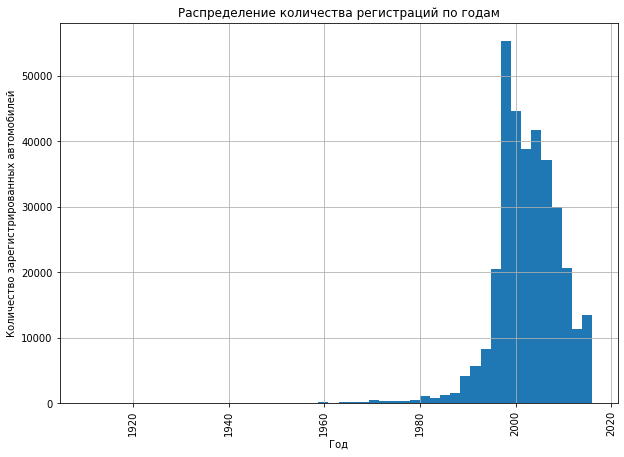

In [8]:
ax = df['RegistrationYear'].hist(bins=50)
ax.set_title('Распределение количества регистраций по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Количество зарегистрированных автомобилей')  
plt.xticks(rotation=90)
plt.show()

На гистограмме видно, что количество зарегистрированных автомобилей начинает расти с 1970-х, так что можем откинуть значения менее 1970.

In [9]:
df = df.query('RegistrationYear>=1970')

Переходим к анализу мощности автомобилей

In [10]:
display(df['Power'].sort_values().unique()) 

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

По данным интернета двигатель автомобиля Lotus Evija имеет максимальное количество лошадиных сил (1972). Однако, если такой у нас и есть, то вряд ли мы сможем адекватно предсказать его стоимость. Так что ограничимся значениями от 40 л.с. до 650 л.с. и посмотрим на распределение оставшихся величин.

In [11]:
df = df.query('Power>=40 and Power<=650')

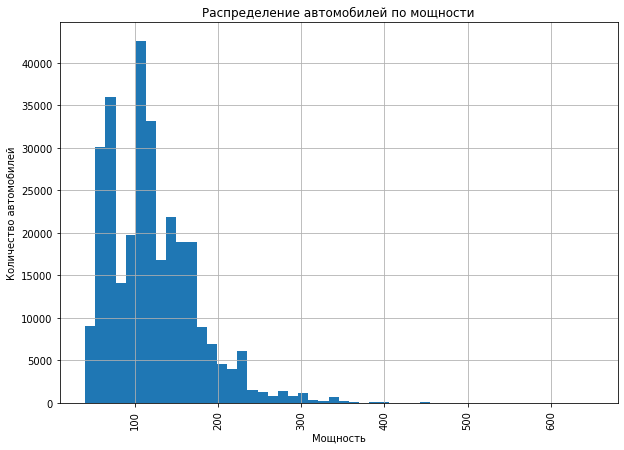

In [12]:
ax = df['Power'].hist(bins=50)
ax.set_title('Распределение автомобилей по мощности')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество автомобилей')  
plt.xticks(rotation=90)
plt.show()

Получилось вполне неплохо.

Проверяем километраж

In [13]:
display(df['Kilometer'].sort_values().unique()) 

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

В данных о пробеге аномальных значений нет, но видно, что значения округлены.

In [14]:
display(df['RegistrationMonth'].sort_values().unique()) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Аномальных значений в номерах месяца нет, но есть 0-е значение, которое не является номером месяца. Подсчитаем, сколько таких.

In [15]:
display(df.query('RegistrationMonth==0')['RegistrationMonth'].count())

19530

Чуть более 10% всех данных по месяцу регистрации получаются не заполненными.     

Проанализируем оставшиеся данные, в т.ч. на предмет орфографических ошибок.

In [16]:
display(df['VehicleType'].sort_values().unique())

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Значения адекватные, орфографических ошибок нет.

In [17]:
display(df['Gearbox'].sort_values().unique())

array(['auto', 'manual', nan], dtype=object)

Значения адекватные, орфографических ошибок нет.

In [18]:
display(df['Brand'].sort_values().unique())

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Значения адекватные, орфографических ошибок нет.

In [19]:
display(df['Model'].sort_values().unique())

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Подсчитаем количество для каждой модели и посмотрим на редко встречающиеся значения.

In [20]:
display(df['Model'].value_counts().tail(20))

delta                 28
b_max                 25
9000                  24
musa                  21
charade               20
materia               17
200                   16
amarok                15
q3                    14
kappa                 13
gl                    12
elefantino             7
i3                     5
kalina                 5
samara                 5
serie_2                4
601                    3
serie_3                3
range_rover_evoque     2
rangerover             2
Name: Model, dtype: int64

range_rover_evoque и rangerover написаны по-разному. Проверим все модели, которых менее 7 штук.

In [21]:
test=['range','601','serie', 'i3', 'kalina', 'samara', 'elefantino']
for i in test:
    display(df[df.Model.str.contains(i).fillna(False)]['Model'].value_counts())
    print('--------------------')

range_rover           70
range_rover_sport     52
range_rover_evoque     2
rangerover             2
Name: Model, dtype: int64

--------------------


601    3
Name: Model, dtype: int64

--------------------


serie_2    4
serie_3    3
Name: Model, dtype: int64

--------------------


i3    5
Name: Model, dtype: int64

--------------------


kalina    5
Name: Model, dtype: int64

--------------------


samara    5
Name: Model, dtype: int64

--------------------


elefantino    7
Name: Model, dtype: int64

--------------------


Получается, что замене подлежит только rangerover на range_rover

In [22]:
df['Model'].replace('rangerover','range_rover', inplace=True)
display(df[df.Model.str.startswith("range").fillna(False)]['Model'].value_counts())

range_rover           72
range_rover_sport     52
range_rover_evoque     2
Name: Model, dtype: int64

Значения подкорректированы

In [23]:
display(df['FuelType'].sort_values().unique())

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Значения адекватные, орфографических ошибок нет.

In [24]:
display(df['Repaired'].sort_values().unique())

array(['no', 'yes', nan], dtype=object)

Значения адекватные, орфографических ошибок нет.

In [25]:
display(df['PostalCode'].sort_values().unique())

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998])

Значения адекватные.    
Проверим оставшиеся поля с датами.

In [26]:
display(df['DateCrawled'].describe())

/tmp/ipykernel_106/3612478304.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df['DateCrawled'].describe())


count                  301060
unique                 240129
top       2016-04-02 22:54:55
freq                        5
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Значения адекватные, несуществующих дат нет.

In [27]:
display(df['DateCreated'].describe())

/tmp/ipykernel_106/2136354472.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df['DateCreated'].describe())


count                  301060
unique                    106
top       2016-04-03 00:00:00
freq                    11840
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

Значения адекватные, несуществующих дат нет.

In [28]:
display(df['LastSeen'].describe())

/tmp/ipykernel_106/1398596278.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df['LastSeen'].describe())


count                  301060
unique                 156593
top       2016-04-06 12:15:45
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Значения адекватные, несуществующих дат нет.

In [29]:
display(df['Price'].describe())

count    301060.000000
mean       4748.739414
std        4611.738697
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64

Значения адекватные, но присутствуют и 0-е значения. Посмотрим на количество слишком малых цен и решим, что делать дальше.

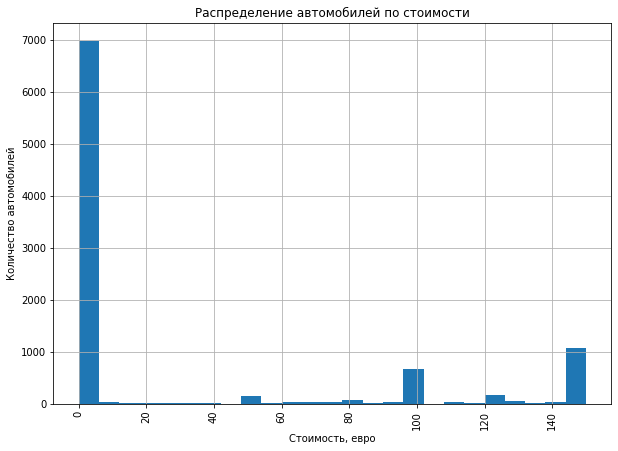

In [30]:
ax = df['Price'].hist(bins=25, range=(0,150))
ax.set_title('Распределение автомобилей по стоимости')
ax.set_xlabel('Стоимость, евро')
ax.set_ylabel('Количество автомобилей')  
plt.xticks(rotation=90)
plt.show()

Из гистограммы видно, что первый всплеск после 0 в районе 50 евро, так что его и примем за будущий минимум цены.

In [31]:
df = df.query('Price>=50')

In [32]:
display(df['PostalCode'].describe())

count    294002.000000
mean      51266.028775
std       25766.939598
min        1067.000000
25%       30952.000000
50%       50321.000000
75%       72108.000000
max       99998.000000
Name: PostalCode, dtype: float64

Присутствуют значения, которые по количеству знаков не соответствуют остальным значениям. Подсчитаем их количество.

In [33]:
display(df.query('PostalCode<10000')['PostalCode'].count())

14268

Итого: 14268 записей с некорректными индексами.

In [34]:
# анализируем дубли
display(df.duplicated().sum())

4

In [35]:
# удаляем дубликаты и выводим контрольную сумму
df = df.drop_duplicates()
display(df.duplicated().sum())

0

**Промежуточный вывод по результатам предобработки данных**:
- формат данных колонок соответствует значениям данных в них,
- найдены пропуски в полях с категориальными данными и принято решение: применить кодировщик при обучении модели машинного обучения,
- найдена ошибка в наименовании модели, проведена замена значения на корректное;
- удалено 4 полных дубликата,
- поле NumberOfPictures содержит одинаковые значения, которые равны 0, так что это поле не будет участвовать в обучении, мы его удалим,
- так же позже удалим поля с датами, которые тоже не повлияют на расчет стоимости.    

    *Аномальные значения содержались в полях:*     
    
- RegistrationYear, но мы их удалили и ограничили выборку значениями **1970-2016**;
- Power, но мы их удалили и ограничили выборку значениями **40л.с. - 650 л.с.**;
- RegistrationMonth, мы приняли решение не использовать столбец в обучении модели и удалить его;
- Price, но мы их удалили, оставив стоимость **выше 50 евро**,
- PostalCode, но как и в случае с месяцем мы решили не использовать этот столбец в дальнейшем обучении. 

**Вывод**: некорректных записей мало, поэтому можно ими пренебречь и удалить.

**Проведем исследовательский анализ данных**, чтобы обнаружить влияние всех признаков на целевой признак.

Посмотрим на распределение данных внутри каждой колонки.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


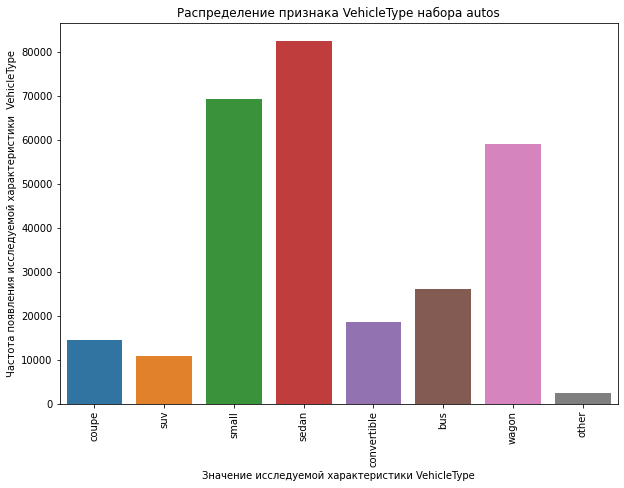

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


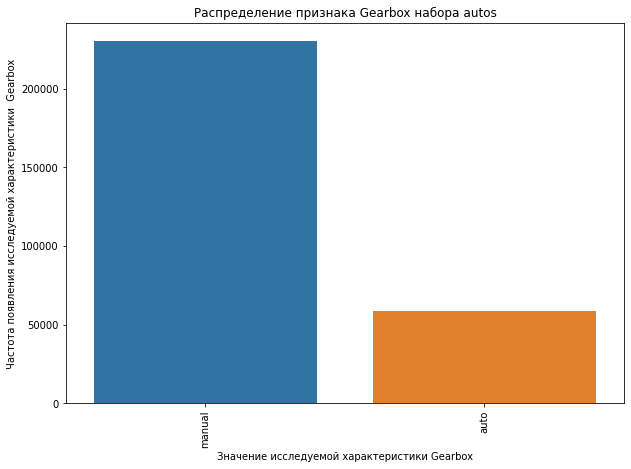

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


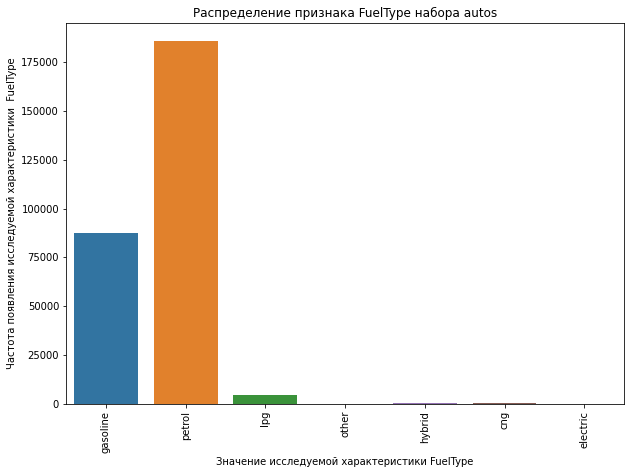

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


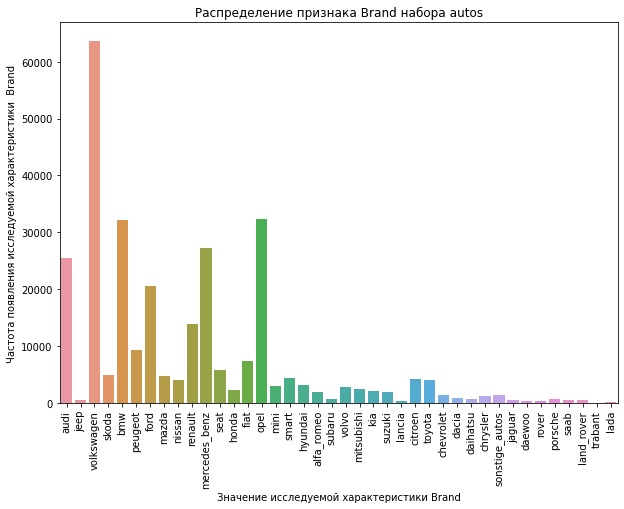

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


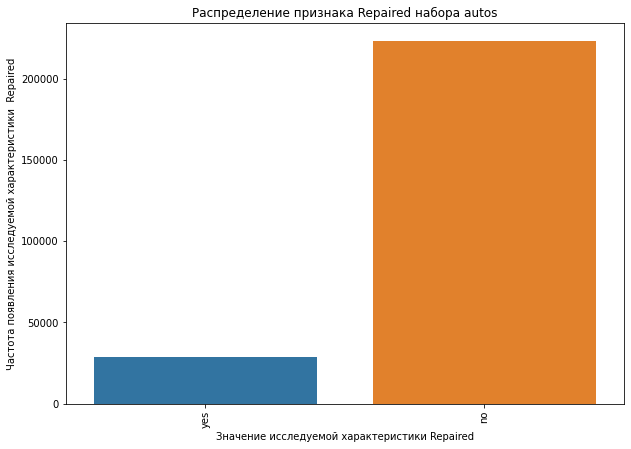

In [36]:
# построим столбчатые диаграммы для колонок с категориальными данными
for i in df.drop('Model', axis=1).select_dtypes('object'):
    ax = sns.countplot(df[i])
    ax.set_title(f'Распределение признака {i} набора autos')
    ax.set_xlabel(f'Значение исследуемой характеристики {i}')
    ax.set_ylabel(f'Частота появления исследуемой характеристики  {i}')  
    plt.xticks(rotation=90)
    plt.show()

**Выводы из построенных графиков**:     

Самые часто встречающиеся типы авто (VehicleType):    
   - sedan,
   - small,
   - wagon.     
   
Самые часто встречающиеся марки авто (Brand):
 - volkswagen,
 - opel,
 - bmw.      
   
Самые часто встречающиеся тип топлива (FuelType):
 - petrol,
 - gasoline,
 - spg.

Машин с механической коробкой передач (GearBox) намного больше, чем с автоматической коробкой.
Машин, побывавших в ремонте (Repaired) сильно меньше, чем новых.

Оставшиеся колонки содержат данные, которые оставшихся колонках относятся к типу дата или целочисленное дискретные значения.     
Посмотрим на общую статистику целочисленных данных.

In [37]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,293998.000000,293998.000000,293998.000000,293998.000000,293998.000000,293998.0,293998.000000
mean,4862.765223,2002.964010,121.030670,128571.503888,6.001861,0.0,51265.815747
std,4607.018559,6.157758,53.684958,36466.769507,3.581795,0.0,25766.950410
min,50.000000,1970.000000,40.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30952.000000
50%,3200.000000,2003.000000,113.000000,150000.000000,6.000000,0.0,50321.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,650.000000,150000.000000,12.000000,0.0,99998.000000


Удалим поля **NumberOfPictures**, поскольку все значения равны 0 и не несут никакого смысла, поля **PostalCode и поля с датами**.     
Построим гистограмму распределения значений для колонки **Price**:

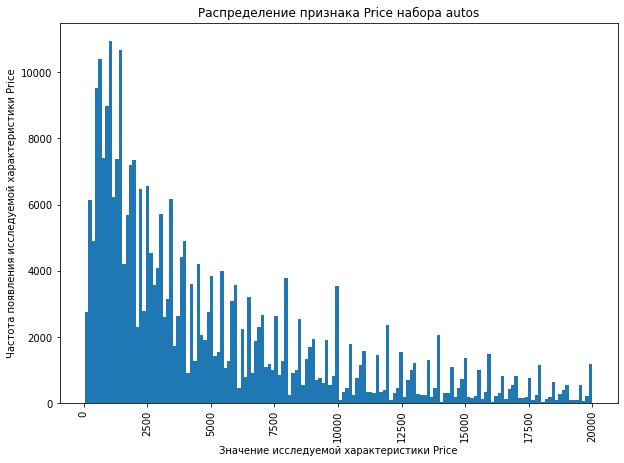

In [38]:
df_auto = df.drop(['NumberOfPictures','PostalCode','LastSeen', 'DateCrawled','DateCreated'], axis=1)

# строим график распределения стоимости автомобилей
ax = df_auto['Price'].plot(kind='hist', bins=150)
ax.set_title(f'Распределение признака Price набора autos')
ax.set_xlabel(f'Значение исследуемой характеристики Price')
ax.set_ylabel(f'Частота появления исследуемой характеристики Price')  
plt.xticks(rotation=90)
plt.show()

Дешевых машин, конечно же, больше, так что график кажется соответствующим действительности.    

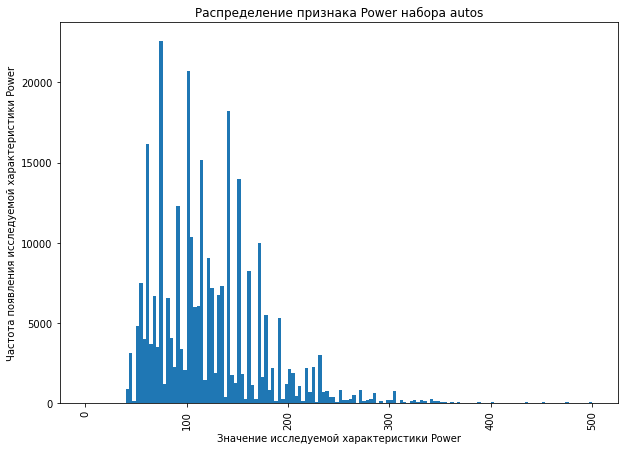

In [39]:
ax = df_auto['Power'].plot(kind='hist', bins=150, range = [0,500])
ax.set_title(f'Распределение признака Power набора autos')
ax.set_xlabel(f'Значение исследуемой характеристики Power')
ax.set_ylabel(f'Частота появления исследуемой характеристики Power')  
plt.xticks(rotation=90)
plt.show()

Значения мощности мы отсеяли ранее (40-650), так что все выглядит правдоподобно, хотя и не очень красиво.

Посмотрим еще раз на распределение количества регистраций автомобиля по годам

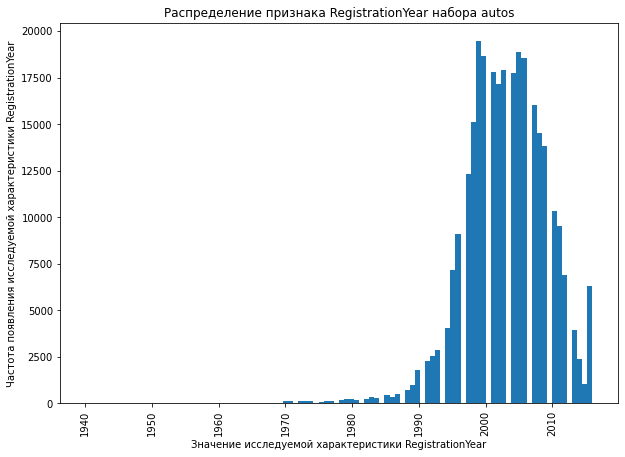

In [40]:
ax = df_auto['RegistrationYear'].plot(kind='hist', bins=100, range = [1940,2016]) 
ax.set_title(f'Распределение признака RegistrationYear набора autos')
ax.set_xlabel(f'Значение исследуемой характеристики RegistrationYear')
ax.set_ylabel(f'Частота появления исследуемой характеристики RegistrationYear')  
plt.xticks(rotation=90)
plt.show()

Пик регистрации автомобилей пришелся на период приблизительно 1998-2007.

Посмотрим на распределение месяца регистрации автомобиля перед его удалением.

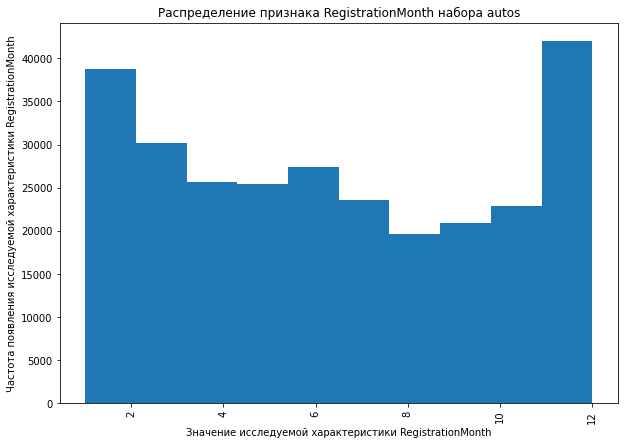

In [41]:
ax = df_auto.query('RegistrationMonth!=0')['RegistrationMonth'].plot(kind='hist', bins=10) 
ax.set_title(f'Распределение признака RegistrationMonth набора autos')
ax.set_xlabel(f'Значение исследуемой характеристики RegistrationMonth')
ax.set_ylabel(f'Частота появления исследуемой характеристики RegistrationMonth')  
plt.xticks(rotation=90)
plt.show()

Вывод такой, что декабре и январе машины покупают чаще. Скидки?    
Удаляем столбец.

In [42]:
df_auto = df_auto.drop('RegistrationMonth', axis=1)

Поскольку мы избавились от столбцов, то проверим наши данные еще раз на дубликаты и удалим их при наличии

In [43]:
df_auto.duplicated().sum()

38964

In [44]:
# удаляем дубликаты
df_auto = df_auto.drop_duplicates()

Посмотрим на распределение пробега автомобиля

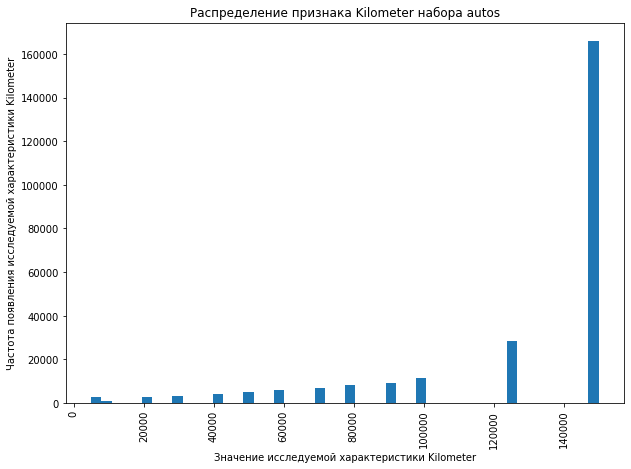

In [45]:
ax = df_auto['Kilometer'].plot(kind='hist', bins=50) 
ax.set_title(f'Распределение признака Kilometer набора autos')
ax.set_xlabel(f'Значение исследуемой характеристики Kilometer')
ax.set_ylabel(f'Частота появления исследуемой характеристики Kilometer')  
plt.xticks(rotation=90)
plt.show()

Много автомобилей с большим пробегом (более 140 000 км). Ничего менять и удалять не будем.

In [46]:
display(df_auto.describe())

,Price,RegistrationYear,Power,Kilometer
count,255034.000000,255034.000000,255034.000000,255034.000000
mean,4950.010171,2003.029047,121.971063,127550.405044
std,4658.204164,6.276391,53.967307,37125.063233
min,50.000000,1970.000000,40.000000,5000.000000
25%,1399.000000,1999.000000,80.000000,125000.000000
50%,3299.000000,2003.000000,115.000000,150000.000000
75%,7100.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,650.000000,150000.000000


Общая статистика подтверждает то, что мы видели при анализе данных.
Перейдем к анализу связи между признаками.     
Воспользуемся библиотекой **phik**.

In [47]:
# задаем столбцы с непрерывными признаками
interval_cols = ['RegistrationYear','Power','Price']

# строим матрицу
corr_matrix = df_auto.phik_matrix(interval_cols = interval_cols)

Построим тепловую карту матрицы корреляции:

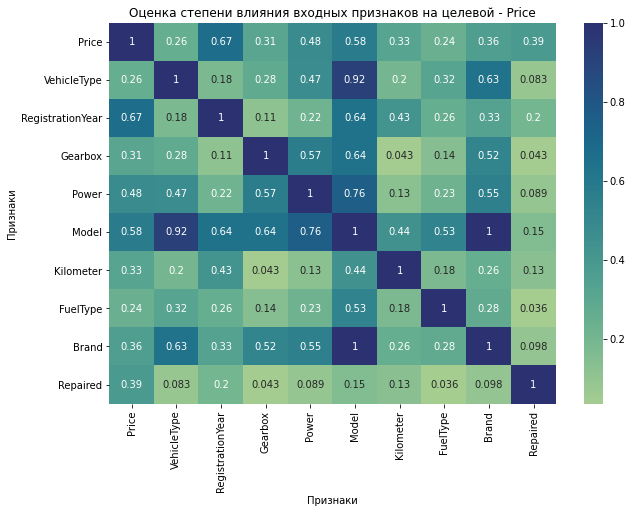

In [48]:
ax = sns.heatmap(corr_matrix, annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - Price')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

Из матрицы мы видим, что целевой признак **Price** имеет ярко выраженную связь с 9-ю признаками:
- 3 самые сильные:
    - **Model** (0.58 - прямая хорошая связь),
    - **RegistrationYear** (0.67 - прямая хорошая связь: чем выше год регистрации (меньше возраст автомобиль), тем выше цена),
    - **Power** (0.50 - прямая хорошая связь: чем больше мощность, тем выше цена),
- 4 средних:
    - **Brand** (0.36 - прямая средняя связь),
    - **Repaired** (0.34 - прямая средняя связь),
    - **Kilometer** (0.33 - прямая средняя связь),   
    - **GearBox** (0.32 - прямая средняя связь).
- 2 слабых:
    - **VehicleType** (0.27- прямая слабая связь),
    - **FuelType** (0.26 - прямая слабая связь).
    
Также мы видим, что связь между **Brand и Model равна 1**, а также связь между **Model и VehicleType равна 0.92**, а это значит, что надо оставить только 1 из этих признаков в парах.
Оставим **Model** из пары Brand и Model.      
Оставим **Model** из пары Model, VehicleType, поскольку влияние на целевой признак у Model в 2 раза выше.

In [49]:
df_auto = df_auto.drop(['Brand','VehicleType'], axis=1)

In [50]:
# считаем еще раз дубликаты и удаляем их
display(df_auto.duplicated().sum())

# удаляем дубликаты после удаления еще 2 колонок
df_auto = df_auto.drop_duplicates()

7502

In [51]:
# перестроим матрицу
corr_matrix = df_auto.phik_matrix(interval_cols = interval_cols)

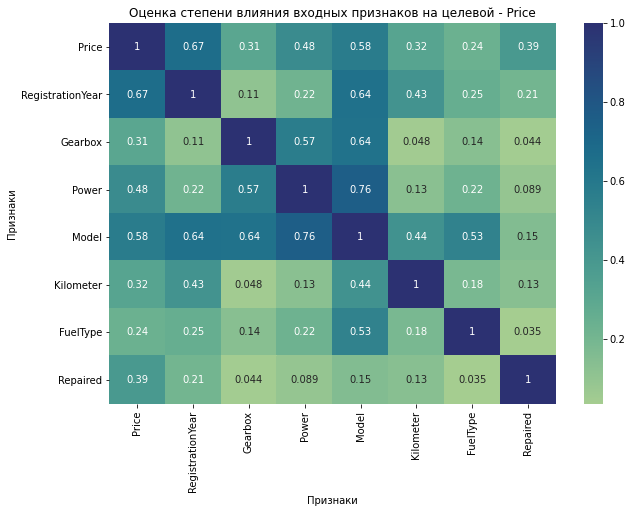

In [52]:
ax = sns.heatmap(corr_matrix, annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - Price')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

**Выводы по результатам предобработки и исследования исходных данных:**     

- формат данных колонок соответствует значениям данных в них,
- найдены пропуски в полях с категориальными данными и принято решение: применить кодировщик при обучении модели машинного обучения,
- найдена ошибка в наименовании модели, проведена замена значения на корректное;
- удалено 4 полных дубликата + 38964 (после первого удаления лишних столбцов) + 7502 (после второго удаления),
- поле NumberOfPictures содержит одинаковые значения, которые равны 0.

**Аномальные значения содержались в полях:**
- RegistrationYear, но мы их удалили и ограничили выборку значениями 1970-2016;
- Power, но мы их удалили и ограничили выборку значениями 40л.с. - 650 л.с.;
- RegistrationMonth, мы приняли решение не использовать столбец в обучении модели и удалить его;
- Price, но мы их удалили, оставив стоимость выше 50 евро.
- PostalCode.

**Удалены поля:**
- NumberOfPictures,
- PostalCode,
- DateCrawled,
- RegistrationMonth,
- DateCreated,
- LastSeen.

*Вывод*: в ходе исследования выяснили, что на целевой признак влияют 9 признаков, из которых мы удалили 2 из-за мультиколлинеарности:
- **Model**,
- **RegistrationYear**,
- **Power**,
- **Repaired**,
- **Kilometer**,   
- **GearBox**,
- **FuelType**.

Удалены признаки:
- Brand,
- VehicleType.

In [53]:
# код ревьюера
df_auto.isna().sum()

Price                   0
RegistrationYear        0
Gearbox              4981
Power                   0
Model               10065
Kilometer               0
FuelType            14692
Repaired            38412
dtype: int64

Пропуски остались в полях с категориальными данными, так что можем добавить вместо отсутствующих значений заглушку

In [54]:
df_auto = df_auto.fillna('unk')

## Обучение моделей

Обучим следующие модели:
- LinearRegression,
- DecisionTreeRegressor,
- CatBoostRegressor,
- LightGBM.

In [55]:
# задаем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# делим наш датасет на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_auto.drop('Price', axis=1),
    df_auto['Price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [56]:
# создаём списки с названиями признаков для кодирования
ohe_columns = ['Gearbox', 'Repaired']
ord_columns = ['Model', 'FuelType']

In [57]:
# создаём списки с количественными признаками
num_columns = ['Power', 'Kilometer', 'RegistrationYear']

In [58]:
gearbox_cat = df_auto[df_auto['Gearbox'].notnull()]['Gearbox'].unique()
model_cat = df_auto[df_auto['Model'].notnull()]['Model'].unique()
fueltype_cat = df_auto[df_auto['FuelType'].notnull()]['FuelType'].unique()
repaired_cat = df_auto[df_auto['Repaired'].notnull()]['Repaired'].unique()

In [59]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values='unk', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

In [60]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [
     ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories= [
                    model_cat,
                    fueltype_cat
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [61]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(transformers=
    [('onehot', ohe_pipe, ohe_columns),
     ('ordinal', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### МОДЕЛЬ LinearRegression

In [62]:
# задаем словарь с гиперпараметрами модели
param_grid_lr = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
}

In [63]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [64]:
# задаем параметры для подбора лучшей модели инструментом GridSearchCV
grid_lr = GridSearchCV(pipe_final_lr, param_grid=param_grid_lr, cv=5, n_jobs=1, verbose=100, scoring= 'neg_mean_squared_error')

In [65]:
%%time

l_start_lr=time.time()
grid_lr.fit(X_train, y_train)
l_end_lr=time.time()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START preprocessor__num=StandardScaler()..........................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 1/3] END ........preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 1/3] START preprocessor__num=StandardScaler()..........................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 1/3] END ........preprocessor__num=StandardScaler(); total time=   0.6s
[CV 3/5; 1/3] START preprocessor__num=StandardScaler()..........................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 1/3] END ........preprocessor__num=StandardScaler(); total time=   0.6s
[CV 4/5; 1/3] START preprocessor__num=StandardScaler()..........................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 1/3] END ........preprocessor__num=StandardScaler(); total time=   0.6s
[CV 5/5; 1/3] START preprocessor__num=StandardScaler()..........................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 1/3] END ........preprocessor__num=StandardScaler(); total time=   0.6s
[CV 1/5; 2/3] START preprocessor__num=MinMaxScaler()............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 2/3] END ..........preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 2/5; 2/3] START preprocessor__num=MinMaxScaler()............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 2/3] END ..........preprocessor__num=MinMaxScaler(); total time=   0.7s
[CV 3/5; 2/3] START preprocessor__num=MinMaxScaler()............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 2/3] END ..........preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 4/5; 2/3] START preprocessor__num=MinMaxScaler()............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 2/3] END ..........preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 2/3] START preprocessor__num=MinMaxScaler()............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 2/3] END ..........preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 3/3] START preprocessor__num=passthrough...............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 3/3] END .............preprocessor__num=passthrough; total time=   0.6s
[CV 2/5; 3/3] START preprocessor__num=passthrough...............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 3/3] END .............preprocessor__num=passthrough; total time=   0.6s
[CV 3/5; 3/3] START preprocessor__num=passthrough...............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 3/3] END .............preprocessor__num=passthrough; total time=   0.6s
[CV 4/5; 3/3] START preprocessor__num=passthrough...............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 3/3] END .............preprocessor__num=passthrough; total time=   0.6s
[CV 5/5; 3/3] START preprocessor__num=passthrough...............................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 3/3] END .............preprocessor__num=passthrough; total time=   0.7s
CPU times: user 8.08 s, sys: 1.66 s, total: 9.74 s
Wall time: 9.84 s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [66]:
# выводим на экран параметры лучшей модели для LinearRegression
print('Лучшая модель и её параметры:\n\n', grid_lr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_lr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_lr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(missing_values='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
               

In [67]:
# выведем результаты перебора всех моделей с параметрами
result_lr = pd.DataFrame(grid_lr.cv_results_)
print(result_lr[
    ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
].sort_values('rank_test_score'))

   rank_test_score  mean_test_score  mean_fit_time  mean_score_time  \
2                1    -9.054543e+06       0.485295         0.133976   
1                2    -9.054543e+06       0.472664         0.120151   
0                3    -9.054543e+06       0.463010         0.118831   

                                    params  
2     {'preprocessor__num': 'passthrough'}  
1    {'preprocessor__num': MinMaxScaler()}  
0  {'preprocessor__num': StandardScaler()}  


**Выводы по LinearRegression:**    
Метрика RMSE, полученная для лучшей модели **LinearRegression** кросс-валидацией, получилась равной **3009.08**.

In [68]:
print(f'Общее время, которое понадобилось для обучения модели, составило:', round(result_lr['mean_fit_time'].mean(),2))
print(f'Общее время, которое понадобилось для предсказания моделью, составило: ', round(result_lr['mean_score_time'].mean(),2))

Общее время, которое понадобилось для обучения модели, составило: 0.47
Общее время, которое понадобилось для предсказания моделью, составило:  0.12


### МОДЕЛЬ DecisionTreeRegressor

In [69]:
# задаем словарь с гиперпараметрами модели
param_grid_dtr = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models__criterion':['friedman_mse'],
    'models__max_depth': range(2,9)
}

In [70]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_dtr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [71]:
# задаем параметры для подбора лучшей модели инструментом GridSearchCV
grid_dtr = GridSearchCV(pipe_final_dtr, param_grid_dtr, cv=5, n_jobs=1, verbose=100, scoring='neg_mean_squared_error')

In [72]:
%%time
l_start_dtr=time.time()
grid_dtr.fit(X_train, y_train)
l_end_dtr=time.time()

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5; 1/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 1/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler(); total time=   0.4s
[CV 2/5; 1/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 1/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler(); total time=   0.4s
[CV 3/5; 1/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 1/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler(); total time=   0.4s
[CV 4/5; 1/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 1/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler(); total time=   0.4s
[CV 5/5; 1/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 1/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=StandardScaler(); total time=   0.4s
[CV 1/5; 2/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 2/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler(); total time=   0.4s
[CV 2/5; 2/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 2/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler(); total time=   0.4s
[CV 3/5; 2/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 2/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler(); total time=   0.4s
[CV 4/5; 2/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 2/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler(); total time=   0.4s
[CV 5/5; 2/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 2/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 3/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 3/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough; total time=   0.5s
[CV 2/5; 3/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 3/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough; total time=   0.4s
[CV 3/5; 3/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 3/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough; total time=   0.4s
[CV 4/5; 3/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 3/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough; total time=   0.4s
[CV 5/5; 3/21] START models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 3/21] END models__criterion=friedman_mse, models__max_depth=2, preprocessor__num=passthrough; total time=   0.4s
[CV 1/5; 4/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 4/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 4/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 4/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 3/5; 4/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 4/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 4/5; 4/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 4/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 5/5; 4/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 4/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 1/5; 5/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 5/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 2/5; 5/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 5/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 3/5; 5/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 5/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 4/5; 5/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 5/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 5/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 5/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=MinMaxScaler(); total time=   0.4s
[CV 1/5; 6/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 6/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough; total time=   0.5s
[CV 2/5; 6/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 6/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough; total time=   0.5s
[CV 3/5; 6/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 6/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough; total time=   0.4s
[CV 4/5; 6/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 6/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough; total time=   0.4s
[CV 5/5; 6/21] START models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 6/21] END models__criterion=friedman_mse, models__max_depth=3, preprocessor__num=passthrough; total time=   0.4s
[CV 1/5; 7/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 7/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 7/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 7/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 3/5; 7/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 7/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 4/5; 7/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 7/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 5/5; 7/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 7/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 1/5; 8/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 8/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 2/5; 8/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 8/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 3/5; 8/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 8/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 4/5; 8/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 8/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 8/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 8/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 9/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 9/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough; total time=   0.5s
[CV 2/5; 9/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 9/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough; total time=   0.5s
[CV 3/5; 9/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 9/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough; total time=   0.5s
[CV 4/5; 9/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 9/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough; total time=   0.5s
[CV 5/5; 9/21] START models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 9/21] END models__criterion=friedman_mse, models__max_depth=4, preprocessor__num=passthrough; total time=   0.5s
[CV 1/5; 10/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 10/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 10/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 10/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 3/5; 10/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 10/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 4/5; 10/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 10/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 5/5; 10/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 10/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 1/5; 11/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 11/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 2/5; 11/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 11/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 3/5; 11/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 11/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 4/5; 11/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 11/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 11/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 11/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 12/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 12/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough; total time=   0.5s
[CV 2/5; 12/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 12/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough; total time=   0.5s
[CV 3/5; 12/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 12/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough; total time=   0.5s
[CV 4/5; 12/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 12/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough; total time=   0.5s
[CV 5/5; 12/21] START models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 12/21] END models__criterion=friedman_mse, models__max_depth=5, preprocessor__num=passthrough; total time=   0.5s
[CV 1/5; 13/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 13/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 13/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 13/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 3/5; 13/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 13/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 4/5; 13/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 13/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 5/5; 13/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 13/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 1/5; 14/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 14/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 2/5; 14/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 14/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 3/5; 14/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 14/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 4/5; 14/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 14/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 14/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 14/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 15/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 15/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough; total time=   0.5s
[CV 2/5; 15/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 15/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough; total time=   0.5s
[CV 3/5; 15/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 15/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough; total time=   0.5s
[CV 4/5; 15/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 15/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough; total time=   0.5s
[CV 5/5; 15/21] START models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 15/21] END models__criterion=friedman_mse, models__max_depth=6, preprocessor__num=passthrough; total time=   0.5s
[CV 1/5; 16/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 16/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 2/5; 16/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 16/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 3/5; 16/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 16/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 4/5; 16/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 16/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 5/5; 16/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 16/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 1/5; 17/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 17/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 2/5; 17/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 17/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 3/5; 17/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 17/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 4/5; 17/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 17/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 5/5; 17/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 17/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 1/5; 18/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 18/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough; total time=   0.6s
[CV 2/5; 18/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 18/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough; total time=   0.5s
[CV 3/5; 18/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 18/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough; total time=   0.6s
[CV 4/5; 18/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 18/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough; total time=   0.6s
[CV 5/5; 18/21] START models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 18/21] END models__criterion=friedman_mse, models__max_depth=7, preprocessor__num=passthrough; total time=   0.6s
[CV 1/5; 19/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 19/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 2/5; 19/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 19/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler(); total time=   0.5s
[CV 3/5; 19/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 19/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 4/5; 19/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 19/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 5/5; 19/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 19/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=StandardScaler(); total time=   0.6s
[CV 1/5; 20/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 20/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 2/5; 20/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 20/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler(); total time=   0.5s
[CV 3/5; 20/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 20/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 4/5; 20/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 20/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 5/5; 20/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler()


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 20/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=MinMaxScaler(); total time=   0.6s
[CV 1/5; 21/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 21/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough; total time=   0.6s
[CV 2/5; 21/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 21/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough; total time=   0.6s
[CV 3/5; 21/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 21/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough; total time=   0.6s
[CV 4/5; 21/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 21/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough; total time=   0.6s
[CV 5/5; 21/21] START models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 21/21] END models__criterion=friedman_mse, models__max_depth=8, preprocessor__num=passthrough; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


CPU times: user 53.3 s, sys: 199 ms, total: 53.5 s
Wall time: 54.2 s


In [73]:
# выводим на экран параметры лучшей модели для DecisionTreeRegressor
print('Лучшая модель и её параметры:\n\n', grid_dtr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_dtr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_dtr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(missing_values='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
               

In [74]:
# выведем результаты перебора всех моделей с параметрами
result_dtr = pd.DataFrame(grid_dtr.cv_results_)
print(result_dtr[
    ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
].sort_values('rank_test_score'))

    rank_test_score  mean_test_score  mean_fit_time  mean_score_time  \
19                1    -4.745122e+06       0.511694         0.063221   
20                2    -4.745397e+06       0.516155         0.061958   
18                3    -4.745516e+06       0.511728         0.063453   
16                4    -5.055893e+06       0.476821         0.059748   
17                5    -5.055936e+06       0.490782         0.061110   
15                6    -5.056038e+06       0.480982         0.062229   
14                7    -5.449033e+06       0.451885         0.056428   
13                8    -5.449105e+06       0.458269         0.061629   
12                9    -5.449173e+06       0.475440         0.058805   
11               10    -6.094290e+06       0.432139         0.062543   
9                10    -6.094290e+06       0.450249         0.057287   
10               12    -6.094340e+06       0.448538         0.059120   
7                13    -6.990574e+06       0.441686         0.05

**Выводы по DecisionTreeRegressor:**    
Метрика RMSE, полученная для лучшей модели **DecisionTreeRegressor** кросс-валидацией, получилась равной **2178.33**.

In [75]:
print(f'Общее время, которое понадобилось для обучения модели, составило:', round(result_dtr['mean_fit_time'].mean(),2))
print(f'Общее время, которое понадобилось для предсказания моделью, составило: ', round(result_dtr['mean_score_time'].mean(),2))

Общее время, которое понадобилось для обучения модели, составило: 0.45
Общее время, которое понадобилось для предсказания моделью, составило:  0.06


### МОДЕЛЬ CatBoostRegressor

In [76]:
# задаем словарь с гиперпараметрами модели
param_grid_cbr = {
    'models__learning_rate':[0.5, 0.8]
}

In [77]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_cbr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(random_state=RANDOM_STATE))
])

In [78]:
# задаем параметры для подбора лучшей модели инструментом GridSearchCV
grid_cbr = GridSearchCV(pipe_final_cbr, param_grid=param_grid_cbr, cv=5, n_jobs=1, verbose=100, scoring='neg_mean_squared_error')

In [79]:
%%time
l_start_cbr = time.time()
grid_cbr.fit(X_train, y_train)
l_end_cbr = time.time()

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START models__learning_rate=0.5...................................


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3291.8500267	total: 73.8ms	remaining: 1m 13s
1:	learn: 2689.2132767	total: 93.1ms	remaining: 46.5s
2:	learn: 2390.4644969	total: 124ms	remaining: 41.2s
3:	learn: 2285.5143904	total: 144ms	remaining: 35.7s
4:	learn: 2230.3428136	total: 162ms	remaining: 32.3s
5:	learn: 2197.7455097	total: 182ms	remaining: 30.1s
6:	learn: 2180.0101400	total: 200ms	remaining: 28.4s
7:	learn: 2160.4254125	total: 222ms	remaining: 27.5s
8:	learn: 2114.6833759	total: 242ms	remaining: 26.7s
9:	learn: 2102.1761994	total: 261ms	remaining: 25.8s
10:	learn: 2088.9888832	total: 282ms	remaining: 25.3s
11:	learn: 2077.9064591	total: 304ms	remaining: 25.1s
12:	learn: 2068.9723414	total: 325ms	remaining: 24.7s
13:	learn: 2060.4596526	total: 346ms	remaining: 24.3s
14:	learn: 2051.9677267	total: 367ms	remaining: 24.1s
15:	learn: 2039.5686758	total: 388ms	remaining: 23.9s
16:	learn: 2032.5761202	total: 410ms	remaining: 23.7s
17:	learn: 2027.9235434	total: 428ms	remaining: 23.3s
18:	learn: 2019.2295960	total: 447m

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3300.9592876	total: 31.2ms	remaining: 31.2s
1:	learn: 2703.0833011	total: 50.4ms	remaining: 25.2s
2:	learn: 2405.5620642	total: 69ms	remaining: 22.9s
3:	learn: 2299.5605141	total: 87ms	remaining: 21.7s
4:	learn: 2244.3039615	total: 104ms	remaining: 20.8s
5:	learn: 2206.8635700	total: 129ms	remaining: 21.4s
6:	learn: 2185.7707136	total: 146ms	remaining: 20.7s
7:	learn: 2150.8915629	total: 162ms	remaining: 20.1s
8:	learn: 2134.2527328	total: 180ms	remaining: 19.8s
9:	learn: 2122.3569845	total: 197ms	remaining: 19.5s
10:	learn: 2112.0710225	total: 216ms	remaining: 19.4s
11:	learn: 2098.2206721	total: 234ms	remaining: 19.2s
12:	learn: 2092.4081267	total: 253ms	remaining: 19.2s
13:	learn: 2085.0063798	total: 270ms	remaining: 19s
14:	learn: 2078.5957197	total: 288ms	remaining: 18.9s
15:	learn: 2064.7898065	total: 311ms	remaining: 19.1s
16:	learn: 2051.4975389	total: 331ms	remaining: 19.2s
17:	learn: 2044.5863523	total: 349ms	remaining: 19s
18:	learn: 2031.3603071	total: 369ms	remai

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3298.0743386	total: 19.2ms	remaining: 19.2s
1:	learn: 2694.8798580	total: 38.7ms	remaining: 19.3s
2:	learn: 2416.6408898	total: 57.7ms	remaining: 19.2s
3:	learn: 2297.9015104	total: 76.4ms	remaining: 19s
4:	learn: 2228.2895390	total: 99.7ms	remaining: 19.8s
5:	learn: 2200.1435541	total: 118ms	remaining: 19.6s
6:	learn: 2177.5291026	total: 138ms	remaining: 19.6s
7:	learn: 2131.2982897	total: 159ms	remaining: 19.7s
8:	learn: 2118.8205169	total: 178ms	remaining: 19.6s
9:	learn: 2104.2985459	total: 202ms	remaining: 19.9s
10:	learn: 2092.7108853	total: 220ms	remaining: 19.8s
11:	learn: 2081.1574534	total: 238ms	remaining: 19.6s
12:	learn: 2070.6062948	total: 257ms	remaining: 19.5s
13:	learn: 2060.0762035	total: 276ms	remaining: 19.4s
14:	learn: 2052.2109163	total: 293ms	remaining: 19.3s
15:	learn: 2035.9295513	total: 314ms	remaining: 19.3s
16:	learn: 2031.3028160	total: 332ms	remaining: 19.2s
17:	learn: 2020.1104876	total: 351ms	remaining: 19.1s
18:	learn: 2012.9102852	total: 369m

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3298.4251004	total: 17.7ms	remaining: 17.6s
1:	learn: 2684.1844650	total: 36.4ms	remaining: 18.1s
2:	learn: 2410.2336496	total: 59.3ms	remaining: 19.7s
3:	learn: 2287.3742600	total: 77.4ms	remaining: 19.3s
4:	learn: 2232.4619375	total: 94.3ms	remaining: 18.8s
5:	learn: 2197.4000601	total: 111ms	remaining: 18.4s
6:	learn: 2174.6095213	total: 128ms	remaining: 18.1s
7:	learn: 2129.7714917	total: 152ms	remaining: 18.9s
8:	learn: 2116.6405583	total: 170ms	remaining: 18.7s
9:	learn: 2098.9972633	total: 188ms	remaining: 18.6s
10:	learn: 2085.8009573	total: 206ms	remaining: 18.5s
11:	learn: 2075.7200392	total: 224ms	remaining: 18.5s
12:	learn: 2068.6445999	total: 246ms	remaining: 18.7s
13:	learn: 2058.6729541	total: 266ms	remaining: 18.7s
14:	learn: 2051.5654153	total: 282ms	remaining: 18.5s
15:	learn: 2033.9618300	total: 301ms	remaining: 18.5s
16:	learn: 2027.7937184	total: 319ms	remaining: 18.5s
17:	learn: 2019.7235036	total: 344ms	remaining: 18.8s
18:	learn: 2015.9400335	total: 36

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3300.9538869	total: 18ms	remaining: 18s
1:	learn: 2695.1324809	total: 36.7ms	remaining: 18.3s
2:	learn: 2416.1376832	total: 53.9ms	remaining: 17.9s
3:	learn: 2295.6637710	total: 78.8ms	remaining: 19.6s
4:	learn: 2234.8330952	total: 98ms	remaining: 19.5s
5:	learn: 2202.9097175	total: 119ms	remaining: 19.7s
6:	learn: 2178.3144380	total: 139ms	remaining: 19.7s
7:	learn: 2157.8650125	total: 159ms	remaining: 19.7s
8:	learn: 2115.7367732	total: 179ms	remaining: 19.7s
9:	learn: 2104.1852565	total: 199ms	remaining: 19.7s
10:	learn: 2094.3078366	total: 218ms	remaining: 19.6s
11:	learn: 2086.3677320	total: 235ms	remaining: 19.4s
12:	learn: 2076.3243179	total: 252ms	remaining: 19.2s
13:	learn: 2069.7896594	total: 279ms	remaining: 19.6s
14:	learn: 2059.1091001	total: 295ms	remaining: 19.4s
15:	learn: 2054.6350294	total: 313ms	remaining: 19.2s
16:	learn: 2044.9123272	total: 331ms	remaining: 19.1s
17:	learn: 2031.7941718	total: 350ms	remaining: 19.1s
18:	learn: 2027.7755954	total: 374ms	re

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 2786.3532971	total: 18.7ms	remaining: 18.7s
1:	learn: 2424.2979043	total: 39.6ms	remaining: 19.8s
2:	learn: 2299.0387385	total: 71.2ms	remaining: 23.7s
3:	learn: 2246.3574495	total: 90ms	remaining: 22.4s
4:	learn: 2217.3777058	total: 107ms	remaining: 21.4s
5:	learn: 2162.3260550	total: 127ms	remaining: 21s
6:	learn: 2140.6633461	total: 154ms	remaining: 21.8s
7:	learn: 2113.5492876	total: 173ms	remaining: 21.4s
8:	learn: 2095.6327582	total: 192ms	remaining: 21.1s
9:	learn: 2072.7828246	total: 211ms	remaining: 20.8s
10:	learn: 2061.7191832	total: 237ms	remaining: 21.3s
11:	learn: 2048.1302828	total: 258ms	remaining: 21.3s
12:	learn: 2040.3322803	total: 277ms	remaining: 21s
13:	learn: 2032.2027414	total: 295ms	remaining: 20.8s
14:	learn: 2020.9711910	total: 313ms	remaining: 20.6s
15:	learn: 2007.3772990	total: 337ms	remaining: 20.8s
16:	learn: 1997.9268500	total: 359ms	remaining: 20.8s
17:	learn: 1980.7817529	total: 379ms	remaining: 20.7s
18:	learn: 1972.7600098	total: 398ms	rem

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 2794.8472193	total: 19.8ms	remaining: 19.8s
1:	learn: 2438.3653466	total: 38.4ms	remaining: 19.1s
2:	learn: 2311.1016246	total: 57.9ms	remaining: 19.2s
3:	learn: 2263.6665949	total: 83.9ms	remaining: 20.9s
4:	learn: 2226.3184876	total: 104ms	remaining: 20.6s
5:	learn: 2187.3559964	total: 123ms	remaining: 20.4s
6:	learn: 2168.2776691	total: 142ms	remaining: 20.1s
7:	learn: 2126.1246904	total: 167ms	remaining: 20.7s
8:	learn: 2112.8445734	total: 188ms	remaining: 20.6s
9:	learn: 2089.8591668	total: 207ms	remaining: 20.4s
10:	learn: 2076.9308081	total: 226ms	remaining: 20.3s
11:	learn: 2060.2238031	total: 245ms	remaining: 20.2s
12:	learn: 2051.6723624	total: 264ms	remaining: 20.1s
13:	learn: 2041.7530781	total: 287ms	remaining: 20.2s
14:	learn: 2032.5483496	total: 305ms	remaining: 20s
15:	learn: 2024.7015513	total: 326ms	remaining: 20.1s
16:	learn: 2017.0766778	total: 344ms	remaining: 19.9s
17:	learn: 2007.0624621	total: 369ms	remaining: 20.1s
18:	learn: 1989.6351891	total: 388ms

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 2790.9729976	total: 20.3ms	remaining: 20.3s
1:	learn: 2431.6651767	total: 38.1ms	remaining: 19s
2:	learn: 2303.9925613	total: 56.3ms	remaining: 18.7s
3:	learn: 2252.3379342	total: 80.8ms	remaining: 20.1s
4:	learn: 2214.0608502	total: 99.3ms	remaining: 19.8s
5:	learn: 2157.2500822	total: 120ms	remaining: 19.9s
6:	learn: 2137.2119446	total: 138ms	remaining: 19.6s
7:	learn: 2122.9615560	total: 158ms	remaining: 19.6s
8:	learn: 2099.1843716	total: 185ms	remaining: 20.4s
9:	learn: 2084.8185414	total: 210ms	remaining: 20.8s
10:	learn: 2056.0825212	total: 236ms	remaining: 21.2s
11:	learn: 2042.5426866	total: 267ms	remaining: 21.9s
12:	learn: 2028.8195236	total: 288ms	remaining: 21.9s
13:	learn: 2021.7288264	total: 310ms	remaining: 21.9s
14:	learn: 2015.0343749	total: 327ms	remaining: 21.5s
15:	learn: 2005.8104590	total: 345ms	remaining: 21.2s
16:	learn: 2000.0319949	total: 364ms	remaining: 21s
17:	learn: 1992.9036992	total: 387ms	remaining: 21.1s
18:	learn: 1984.4303393	total: 404ms	

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 2791.3776730	total: 18.8ms	remaining: 18.8s
1:	learn: 2431.1151443	total: 35.8ms	remaining: 17.9s
2:	learn: 2312.5403717	total: 57.1ms	remaining: 19s
3:	learn: 2249.3840206	total: 76.4ms	remaining: 19s
4:	learn: 2208.6064593	total: 95.3ms	remaining: 19s
5:	learn: 2161.0249738	total: 113ms	remaining: 18.8s
6:	learn: 2139.0871936	total: 139ms	remaining: 19.7s
7:	learn: 2115.4848260	total: 157ms	remaining: 19.4s
8:	learn: 2095.5704328	total: 174ms	remaining: 19.2s
9:	learn: 2079.4387848	total: 194ms	remaining: 19.2s
10:	learn: 2064.5681325	total: 213ms	remaining: 19.1s
11:	learn: 2048.2058303	total: 243ms	remaining: 20s
12:	learn: 2036.5557991	total: 261ms	remaining: 19.8s
13:	learn: 2024.7170182	total: 280ms	remaining: 19.7s
14:	learn: 2015.1535752	total: 297ms	remaining: 19.5s
15:	learn: 2002.6392273	total: 317ms	remaining: 19.5s
16:	learn: 1995.0483846	total: 337ms	remaining: 19.5s
17:	learn: 1984.0969945	total: 354ms	remaining: 19.3s
18:	learn: 1977.5031790	total: 372ms	rema

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 2796.2915884	total: 19.4ms	remaining: 19.4s
1:	learn: 2433.2098735	total: 36.9ms	remaining: 18.4s
2:	learn: 2305.4950077	total: 54.2ms	remaining: 18s
3:	learn: 2253.5985032	total: 73.1ms	remaining: 18.2s
4:	learn: 2193.5444177	total: 92.5ms	remaining: 18.4s
5:	learn: 2162.8649631	total: 110ms	remaining: 18.2s
6:	learn: 2135.8932854	total: 128ms	remaining: 18.2s
7:	learn: 2113.6720505	total: 146ms	remaining: 18.1s
8:	learn: 2096.9951007	total: 165ms	remaining: 18.2s
9:	learn: 2079.2293074	total: 187ms	remaining: 18.5s
10:	learn: 2057.1074657	total: 205ms	remaining: 18.4s
11:	learn: 2042.6223507	total: 222ms	remaining: 18.3s
12:	learn: 2035.3835211	total: 240ms	remaining: 18.2s
13:	learn: 2026.6148058	total: 264ms	remaining: 18.6s
14:	learn: 2014.5345347	total: 283ms	remaining: 18.6s
15:	learn: 2009.0408020	total: 300ms	remaining: 18.4s
16:	learn: 1994.4576725	total: 318ms	remaining: 18.4s
17:	learn: 1978.8379743	total: 336ms	remaining: 18.3s
18:	learn: 1973.0127839	total: 359m

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0:	learn: 3297.8668526	total: 34ms	remaining: 34s
1:	learn: 2692.5061621	total: 57.4ms	remaining: 28.6s
2:	learn: 2416.8474161	total: 78.9ms	remaining: 26.2s
3:	learn: 2291.4163306	total: 104ms	remaining: 25.9s
4:	learn: 2236.4813492	total: 128ms	remaining: 25.5s
5:	learn: 2200.5621506	total: 149ms	remaining: 24.8s
6:	learn: 2178.2650281	total: 171ms	remaining: 24.3s
7:	learn: 2159.2022969	total: 191ms	remaining: 23.7s
8:	learn: 2113.8465276	total: 218ms	remaining: 24s
9:	learn: 2098.6779977	total: 239ms	remaining: 23.7s
10:	learn: 2087.3289125	total: 261ms	remaining: 23.4s
11:	learn: 2079.0368018	total: 282ms	remaining: 23.2s
12:	learn: 2065.3395901	total: 303ms	remaining: 23s
13:	learn: 2054.9812873	total: 327ms	remaining: 23s
14:	learn: 2047.5439410	total: 349ms	remaining: 22.9s
15:	learn: 2038.9721940	total: 372ms	remaining: 22.9s
16:	learn: 2031.7726809	total: 399ms	remaining: 23.1s
17:	learn: 2024.5226442	total: 422ms	remaining: 23s
18:	learn: 2020.2184970	total: 443ms	remaining:

In [80]:
# выводим на экран параметры лучшей модели для CatBoostRegressor
print('Лучшая модель и её параметры:\n\n', grid_cbr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_cbr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_cbr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(missing_values='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
               

In [81]:
# выведем результаты перебора всех моделей с параметрами
result_cbr = pd.DataFrame(grid_cbr.cv_results_)
print(result_cbr[
    ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
].sort_values('rank_test_score'))

   rank_test_score  mean_test_score  mean_fit_time  mean_score_time  \
0                1    -2.891690e+06      21.109569         0.173041   
1                2    -3.001945e+06      21.734795         0.172870   

                           params  
0  {'models__learning_rate': 0.5}  
1  {'models__learning_rate': 0.8}  


**Выводы по CatBoostRegressor:**    
Метрика RMSE, полученная для лучшей модели **CatBoostRegressor** кросс-валидацией, получилась равной **1700.50**.

In [82]:
print(f'Общее время, которое понадобилось для обучения модели, составило:', round(result_cbr['mean_fit_time'].mean(),2))
print(f'Общее время, которое понадобилось для предсказания моделью, составило: ', round(result_cbr['mean_score_time'].mean(),2))

Общее время, которое понадобилось для обучения модели, составило: 21.42
Общее время, которое понадобилось для предсказания моделью, составило:  0.17


### МОДЕЛЬ LGBMRegressor

In [83]:
# задаем словарь с гиперпараметрами модели
param_grid_lgbmr = {
    'models__num_leaves':[100],
    'models__learning_rate': [0.5]  
}

In [84]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_lgbmr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

In [85]:
# задаем параметры для подбора лучшей модели инструментом GridSearchCV
grid_lgbmr = GridSearchCV(pipe_final_lgbmr, param_grid_lgbmr, cv=5, n_jobs=1, verbose=100, scoring='neg_mean_squared_error')

In [86]:
%%time
l_start_lgbmr = time.time()
grid_lgbmr.fit(X_train, y_train)
l_end_lgbmr = time.time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START models__learning_rate=0.5, models__num_leaves=100...........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 1/1] END models__learning_rate=0.5, models__num_leaves=100; total time= 1.8min
[CV 2/5; 1/1] START models__learning_rate=0.5, models__num_leaves=100...........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 1/1] END models__learning_rate=0.5, models__num_leaves=100; total time= 2.4min
[CV 3/5; 1/1] START models__learning_rate=0.5, models__num_leaves=100...........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 1/1] END models__learning_rate=0.5, models__num_leaves=100; total time= 4.3min
[CV 4/5; 1/1] START models__learning_rate=0.5, models__num_leaves=100...........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 1/1] END models__learning_rate=0.5, models__num_leaves=100; total time= 2.0min
[CV 5/5; 1/1] START models__learning_rate=0.5, models__num_leaves=100...........


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 1/1] END models__learning_rate=0.5, models__num_leaves=100; total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


CPU times: user 14min 11s, sys: 6.42 s, total: 14min 17s
Wall time: 14min 25s


In [87]:
# выводим на экран параметры лучшей модели для LGBMRegressor
print('Лучшая модель и её параметры:\n\n', grid_lgbmr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_lgbmr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_lgbmr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(missing_values='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
               

In [88]:
# выведем результаты перебора всех моделей с параметрами
result_lgbmr = pd.DataFrame(grid_lgbmr.cv_results_)
print(result_lgbmr[
    ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
].sort_values('rank_test_score'))

   rank_test_score  mean_test_score  mean_fit_time  mean_score_time  \
0                1    -2.969226e+06     144.935818         0.340573   

                                              params  
0  {'models__learning_rate': 0.5, 'models__num_le...  


In [89]:
grid_lgbmr.cv_results_

{'mean_fit_time': array([144.93581762]),
 'std_fit_time': array([58.53812522]),
 'mean_score_time': array([0.34057336]),
 'std_score_time': array([0.04710464]),
 'param_models__learning_rate': masked_array(data=[0.5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_models__num_leaves': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'models__learning_rate': 0.5, 'models__num_leaves': 100}],
 'split0_test_score': array([-2942020.42987588]),
 'split1_test_score': array([-2981703.09317749]),
 'split2_test_score': array([-2981797.46033162]),
 'split3_test_score': array([-2948956.11200974]),
 'split4_test_score': array([-2991654.83423548]),
 'mean_test_score': array([-2969226.38592604]),
 'std_test_score': array([19838.26342381]),
 'rank_test_score': array([1], dtype=int32)}

**Выводы по LGBMRegressor:**    
Метрика RMSE, полученная для лучшей модели **LGBMRegressor** кросс-валидацией, получилась равной **1723.14**.

In [90]:
print(f'Общее время, которое понадобилось для обучения модели, составило:', round(result_lgbmr['mean_fit_time'].mean(),2))
print(f'Общее время, которое понадобилось для предсказания моделью, составило: ', round(result_lgbmr['mean_score_time'].mean(),2))

Общее время, которое понадобилось для обучения модели, составило: 144.94
Общее время, которое понадобилось для предсказания моделью, составило:  0.34


Сведем полученные значения в сравнительную таблицу

In [91]:
m_lr = [grid_lr.get_params()['estimator__models'],round(result_lr['mean_fit_time'].mean(),2),
           round(result_lr['mean_score_time'].mean(),2), (grid_lr.best_score_*-1)**0.5]
m_dtr = [grid_dtr.get_params()['estimator__models'],round(result_dtr['mean_fit_time'].mean(),2),
           round(result_dtr['mean_score_time'].mean(),2), (grid_dtr.best_score_*-1)**0.5]
m_cbr = [grid_cbr.get_params()['estimator__models'],round(result_cbr['mean_fit_time'].mean(),2),
           round(result_cbr['mean_score_time'].mean(),2), (grid_cbr.best_score_*-1)**0.5]
m_lgbmr = [grid_lgbmr.get_params()['estimator__models'],round(result_lgbmr['mean_fit_time'].mean(),2),
           round(result_lgbmr['mean_score_time'].mean(),2), (grid_lgbmr.best_score_*-1)**0.5]
col_names = ['model', 'fit_time', 'score_time', 'rmse']

In [92]:
dd=pd.DataFrame([m_lr,m_dtr,m_cbr,m_lgbmr], columns=col_names)
display(dd.sort_values('rmse'))

,model,fit_time,score_time,rmse
2,<catboost.core.CatBoostRegressor object at 0x7...,21.42,0.17,1700.496873
3,LGBMRegressor(random_state=42),144.94,0.34,1723.144331
1,DecisionTreeRegressor(random_state=42),0.45,0.06,2178.330091
0,LinearRegression(),0.47,0.12,3009.076713


**Общий вывод по результатам обучения моделей:**    
Самой точной из построенных моделей оказалась модель градиентного бустинга **CatBoostRegressor** с ошибкой в стоимости автомобиля в **1700 евро**. Однако, эта модель затратила большее количество времени, хотя количество параметров было незначительным. Но лучше не много подождать и сделать прогноз точнее.

## Анализ моделей

Проанализируем отобранную нами модель CatBoostRegressor

### CatBoostRegressor

In [93]:
%%time
# Предскажем значения полученной моделью
p_start_cbr=time.time()
y_pred_cbr = grid_cbr.best_estimator_.predict(X_test)
mse_cbr = mean_squared_error(y_test, y_pred_cbr)
rmse_cbr = mse_cbr ** 0.5
p_end_cbr=time.time()
print('mse: ', mse_cbr)
print('rmse: ', rmse_cbr)
print('rmse_cbr: ',(grid_cbr.best_score_*-1)**0.5)
print('duration_time: ', round(p_end_cbr-p_start_cbr,2))

mse:  2854326.542189426
rmse:  1689.4752268646694
rmse_cbr:  1700.496873465829
duration_time:  0.26
CPU times: user 258 ms, sys: 4.05 ms, total: 262 ms
Wall time: 264 ms


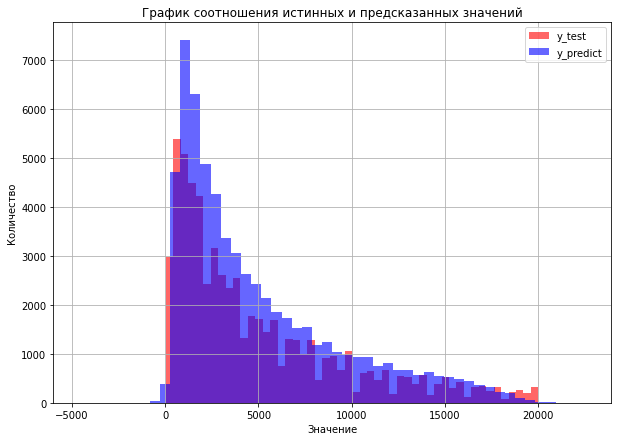

In [94]:
# Отобразим на графике истинные и предсказанные значения
ax=pd.Series(y_test).hist(bins=50, label='y_test', color='red', alpha=0.6)
ax=pd.Series(y_pred_cbr).hist(bins=50, label='y_predict', color='blue', alpha=0.6)
ax.set_title('График соотношения истинных и предсказанных значений')
ax.set_xlabel('Значение')
ax.set_ylabel('Количество')
ax.legend(loc ='upper right')
plt.show()

Посмотрим на важность признаков, что повлияло на результат

In [95]:
feature_importance = grid_cbr.best_estimator_.steps[1][1].feature_importances_
feature_names = X_test.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: RegistrationYear, Importance: 0.95
Feature: Gearbox, Importance: 2.05
Feature: Power, Importance: 15.24
Feature: Model, Importance: 3.89
Feature: Kilometer, Importance: 31.63
Feature: FuelType, Importance: 13.06
Feature: Repaired, Importance: 33.19


In [96]:
feat_imp = pd.DataFrame(feature_importance,
                        index = feature_names,
                        columns=['importance'])

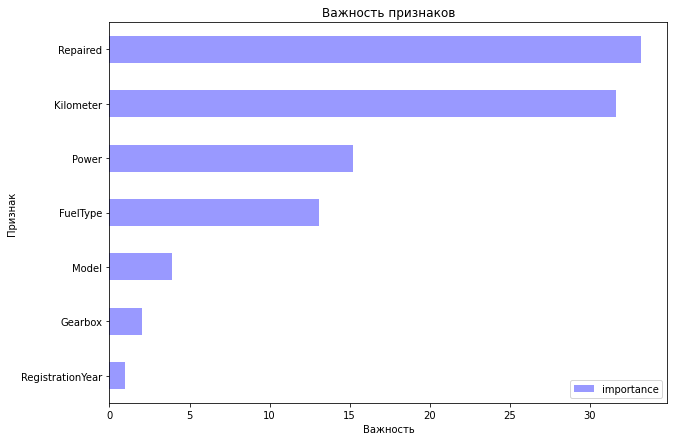

In [97]:
# Отобразим на важность признаков на графике
ax=feat_imp.sort_values('importance').plot(kind ='barh', color='blue', alpha=0.4)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Признак')
plt.show()

Получается, что наша модель откинула признак с самой сильной корреляцией с целевым (RegistrationYear) и даже Model , которая была следующей по уровню, а основала свои выводы на средних величинах.

Вычисляем среднюю ошибку предсказания стоимости на тестовой выборке и соберем показатели лучшей модели в итоговую таблицу

In [98]:
m_cbr.append(round(abs((y_pred_cbr-y_test)).mean(),2))
col_names.append('mean_error')

In [99]:
dd_fin=pd.DataFrame([m_cbr], columns=col_names)
display(dd_fin)

,model,fit_time,score_time,rmse,mean_error
0,<catboost.core.CatBoostRegressor object at 0x7...,21.42,0.17,1700.496873,1075.64


## Общий вывод:

1. Проведен анализ предоставленных заказчиком  данных с характеристиками машин и их стоимостью.     
2. В ходе предобработки и исследования представленных данных проведена их нормализация:
    - удалены дубли,
    - удалены аномальные значения,
    - пропуски временно до обучения заменены на 'unk'.
3. Матрицей корреляции определены признаки, влияющие на целевой признак. На основании матрицы удалены признаки, которые не влияют на результат, а значит только бы мешали обучению и занимали нужную нам память процессора.
4. Выбраны 4 модели для предсказания стоимости автомобиля:
    - LinearRegression,
    - DecisionTreeRegressor,
    - CatBoostRegressor,
    - LightGBM.
5. Собран пайплайн, в котором заполняются пропуски по часто встречающемуся значению в колонке, кодируются и масштабируются признаки.
6. Подобраны гиперпараметры для выбранных моделей.
7. В качестве покзателя точности построения модели выбрана ошибка RMSE, которая определялась на кросс-валидации.
8. Зафиксировано время обучения моделей и построена промежуточная таблица сравнения итоговых показателей построенных моделей.
9. По результатам сравнения выбрана модель градиентного спуска CatBoostRegressor, чьи прогнозы оказались ближе всех к истинным, именно поэтому время (максимальное из всех моделей), которая модель затратила на поиск решения, мы сочли приемлемым
10. Проведен анализ выбранной модели на тестовой выборке, построен график сравнения предсказаний и истинных значений.
11. Сформирована итоговая таблица с основными параметрами выбранной модели CatBoostRegressor.